# hyper-parameter no. - 4
# HYPOTHESIS 

### The number of observations initially considered when trying to figure out the best possible split at each node.

#### Let's call this hyper parameter n_obs_split for ease of reference in the future. I'd like to find out how does the change in this parameter affect the model. I assume it's a trade-off between speed and accuracy, because :

n obs split $\uparrow \hspace{1cm} \Longrightarrow$ number of splits $\downarrow$ (hence speed of algorithm $\uparrow$) $\hspace{1cm}$ $\Longrightarrow$ possibility of finding best split $\downarrow$

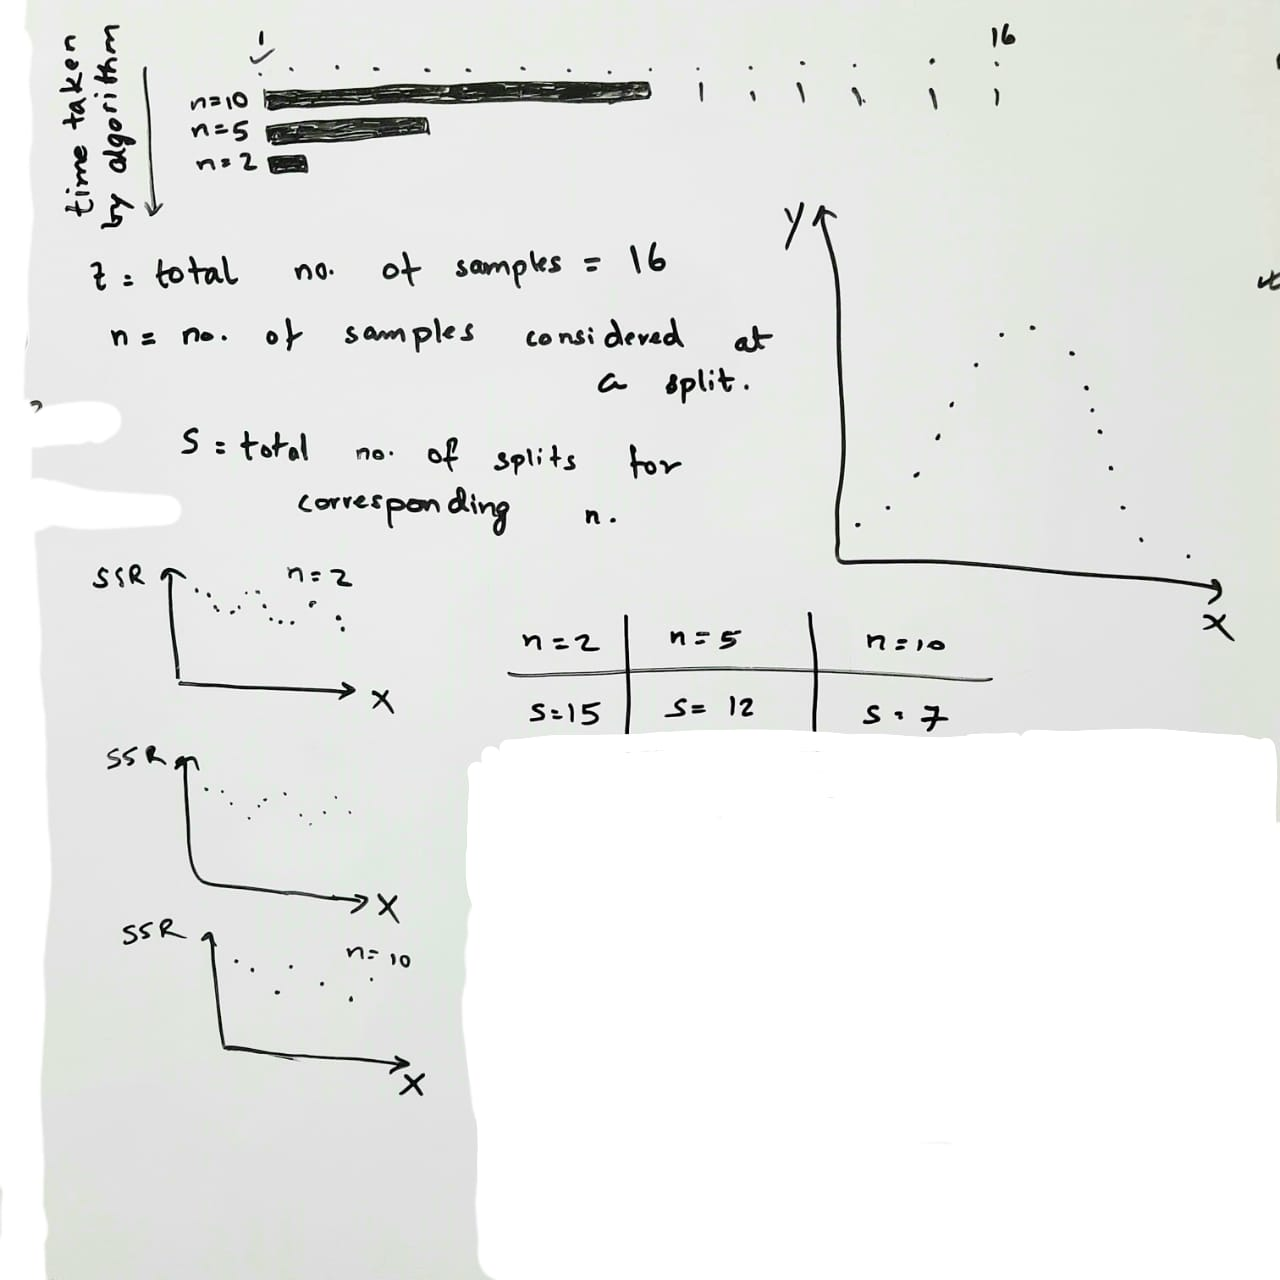

In [5]:
# The above logic would make more sense with a graphical illustration, but since I can't use 
# sklearn.tree.DecisionTreeRegressor because it doesn't allow to tinker with the n_obs_split parameter, I worked out an
# illustration by hand on my whiteboard :P using a simple bell curve as dataset and total number of observations = 16
# Here's the illustration:
Image('n_obs_split illustn.jpeg', height=400,width=800)

### Hence $$ n \propto \frac{1}{splits} \propto \frac{1}{time} $$

In [6]:
# Therefore, the probabilty for the algorithm to miss the actual best split (least SSR) (though by a very small margin) 
# increases as the value of n_obs_split increases, since there will be less splits to make and consider. Since the algo will
# miss by a small margin, but repeatedly missing the best split at each node of the tree may significantly decrease the 
# accuracy of the model/tree.

### Refer to this video if you need to understand how Decision Tree Regression algo works:

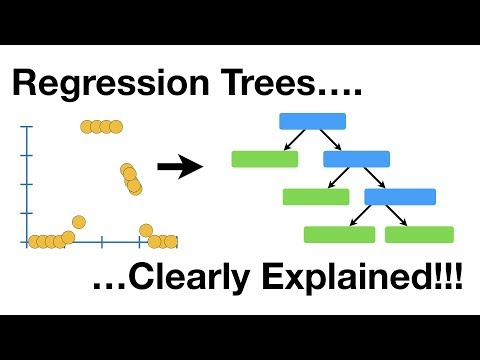

In [1]:
from IPython.display import YouTubeVideo, Image
YouTubeVideo('g9c66TUylZ4', width=850, height=500)

### If my guess is right, I just want to know if the trade-off is significant enough to be considered while training Decision Tree Regression models.

# CODE

In [1]:
import random as r
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

In [2]:
# Let's try it on 2nd hand cars dataset from CARDEKHO.COM
df = pd.read_csv('Car_CarDekho.csv', usecols=['selling_price','km_driven'])
df = df[['km_driven','selling_price']]
df.head()

,km_driven,selling_price
0,70000,60000
1,50000,135000
2,100000,600000
3,46000,250000
4,141000,450000


In [3]:
df.shape

(4340, 2)

In [4]:
%matplotlib notebook

<IPython.core.display.Javascript object>


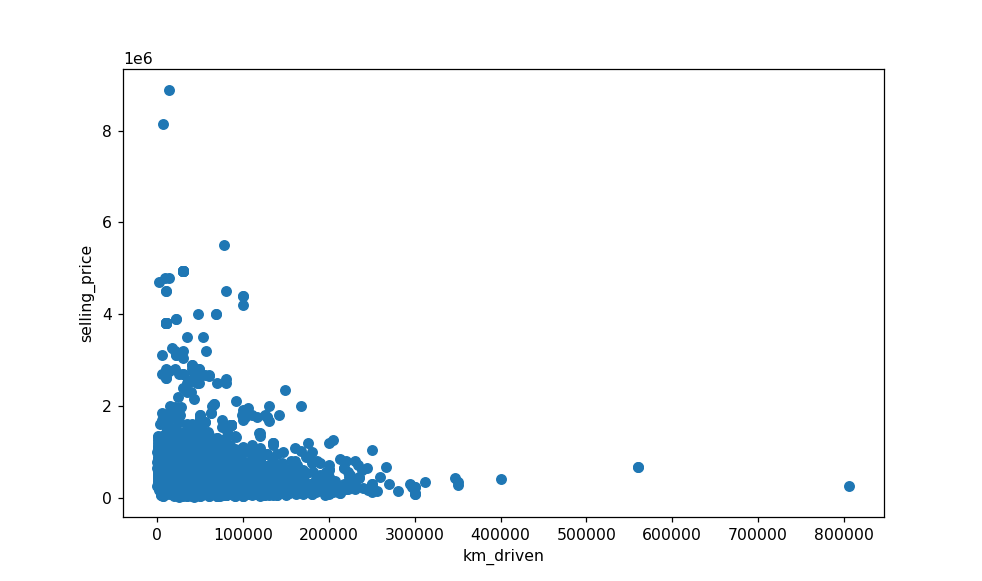

In [8]:
plt.scatter(df['km_driven'],df['selling_price'])
plt.xlabel('km_driven')
plt.ylabel('selling_price')
plt.show()

In [5]:
# dataset ready
# Now lets create a function that returns a dataframe with all of the splits on X for each n. This 
# will calculate the SSR based on the n_obs_split value.

In [10]:
class analyze_n_obs_split:
    
    def __init__(self, X,Y,n_arrs):
        self.X = X
        self.Y = Y
        self.n_arrs = n_arrs
        self.speed = []
        
    
    def get_SSRs(self):        
        self.data = {f"n={x}":[] for x in self.n_arrs}
        
        z = list(zip(self.X, self.Y))
        z = sorted(z)
        
        for n in self.n_arrs:
            timer_start = time.time()                                      # timer kicks off 
            slider_start = 0                                               
            slider_end = n
            while (slider_end!=len(z)+1):
                SSR = 0                                                    # init SSR 
                slider = z[slider_start : slider_end]                      # the observations under consideration for split
                split = sum([x[0] for x in slider])/len(slider)            # the split
                zleft = [left for left in z if left[0]<=split]             # the left set of datapoints
                zright = [right for right in z if right[0]>split]          # the right set of datapoints
                
                left_y_avg = sum([x[1] for x in zleft])/len(zleft)         # the avg Y of left set of dp
                right_y_avg = sum([x[1] for x in zright])/len(zright)      # the avg Y of right set of dp
                
                # calculating SSR from prediction
                for x in zleft:
                    SSR += (x[1] - left_y_avg)**2
                for y in zright:
                    SSR += (y[1] - right_y_avg)**2
                
                #append data
                self.data[f"n={n}"].append([split, SSR])
                
                slider_start += 1
                slider_end += 1
            
            timer_end = time.time()                                          # timer stops
            self.speed.append(timer_end-timer_start)
        
    
    def record_data(self):
        upper_column_names = [f"n={x}" for x in self.n_arrs]                  # upper level column names
        mux = pd.MultiIndex.from_product([upper_column_names, ['X','SSR']])     # creating multi-index
        
        dfs = []
        for x in self.data:
            dfs.append(pd.DataFrame(self.data[f"{x}"]))                      # creating & storing a df for each n
        
        self.df = pd.concat(dfs, axis=1)                                     # merging all dfs
        self.df.columns = mux                                                # naming of columns
        
        
    def run_analysis(self):
        self.get_SSRs()
        self.record_data()
        
    def best_split(self):
        min_SSR = 99999999999999999999
        which_point = None
        for x in self.data:
            for data in self.data[x]:
                if data[1]<min_SSR:
                    min_SSR = data[1]
                    which_point = data 
        return "[X, SSR] :", which_point

### This code runs only for one feature, so to calculate the trade-off on all of the features, we can just  multiply the time taken by algorithm to execute on a particular n by the total number of features (bad approximation though). That should approximately be equal to the time that the algo will take to execute for one split on all features for a particular value of n.

In [54]:
analyser = analyze_n_obs_split(df['km_driven'], df['selling_price'], [100,500,1000])

In [55]:
analyser.run_analysis()

In [56]:
analyser.df.head()

n=100                    n=500                   n=1000              
         X           SSR          X           SSR          X           SSR
0  2587.72  1.449268e+15  10176.902  1.408658e+15  17728.035  1.400836e+15
1  2637.71  1.449268e+15  10216.680  1.409243e+15  17758.034  1.400836e+15
2  2686.70  1.449115e+15  10256.258  1.409243e+15  17787.933  1.400836e+15
3  2735.69  1.449115e+15  10295.836  1.409243e+15  17817.832  1.400836e+15
4  2784.68  1.449232e+15  10335.414  1.409315e+15  17847.731  1.400836e+15

In [57]:
analyser.speed

[16.3702392578125, 14.598830223083496, 12.916444540023804]

In [58]:
# So, if there were, say 10 features, one split on the data, for the corresponding value of n's = [100,500,1000] would take
total_split_time = [x*10 for x in analyser.speed]
total_split_time

[163.702392578125, 145.98830223083496, 129.16444540023804]

#### the results are as expected :
$$ t_{n1} > t_{n2} > t_{n3} $$
#### Since it makes sense that lesser the number of splits to figure out, faster the algorithm.

<IPython.core.display.Javascript object>


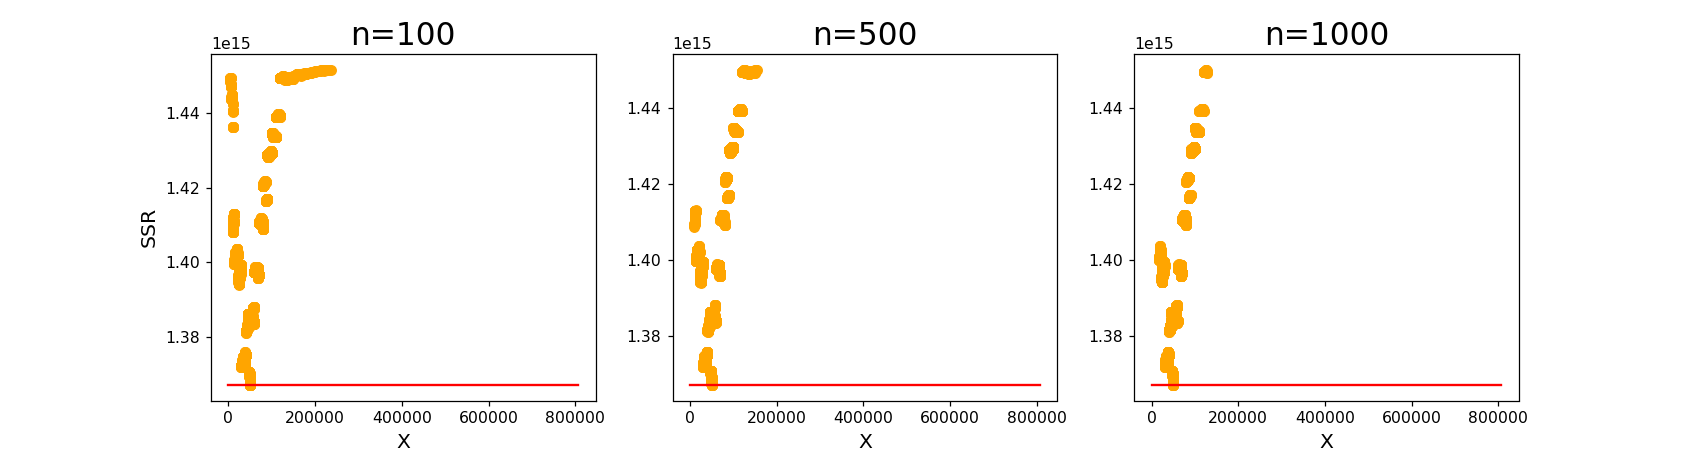

Text(0.5, 1.0, 'n=1000')

In [59]:
fig, axs = plt.subplots(1,3, figsize=(15,4))

axs[0].scatter(analyser.df.loc[:, ('n=100','X')], analyser.df.loc[:, ('n=100','SSR')], c='orange')
axs[0].plot([analyser.X.min(),analyser.X.max()],[analyser.best_split()[1][1], analyser.best_split()[1][1]], c='red')
axs[0].set_xlabel('X', fontsize=13)
axs[0].set_ylabel('SSR', fontsize=13)
axs[0].set_title('n=100', fontsize=20)

axs[1].scatter(analyser.df.loc[:, ('n=500','X')], analyser.df.loc[:, ('n=500','SSR')], c='orange')
axs[1].plot([analyser.X.min(),analyser.X.max()],[analyser.best_split()[1][1], analyser.best_split()[1][1]], c='red')
axs[1].set_xlabel('X', fontsize=13)
axs[1].set_title('n=500', fontsize=20)


axs[2].scatter(analyser.df.loc[:, ('n=1000','X')], analyser.df.loc[:, ('n=1000','SSR')], c='orange')
axs[2].plot([analyser.X.min(),analyser.X.max()],[analyser.best_split()[1][1], analyser.best_split()[1][1]], c='red')
axs[2].set_xlabel('X', fontsize=13)
axs[2].set_title('n=1000', fontsize=20)

In [60]:
analyser.best_split()

('[X, SSR] :', [49657.42, 1367157338158966.8])

In [62]:
SSRs = analyser.df.iloc[:,1].min(), analyser.df.iloc[:,3].min(), analyser.df.iloc[:,5].min()
for n,ssr in zip(analyser.n_arrs, SSRs):
    print('n = {} :: minimum SSR on X = {}'.format(n,ssr))

n = 100 :: minimum SSR on X = 1367157338158966.8
n = 500 :: minimum SSR on X = 1367157338158966.8
n = 1000 :: minimum SSR on X = 1367157338158966.8


<b>Even though n varies significantly (from 0.1K to 1K), the best split (i.e. split with least SSR) is always found in all the 3 cases. This indicates that we can boost the speed of Decision Tree Regression algorithm to a great extent with maybe almost no loss in accuracy of the model. But this would require a whole lot of testing on diffirent datasets, with different n values, and then calculating some sort of probablistic statistic to conclude a solid report on this hypothesis.</b>

In [71]:
from sklearn.tree import DecisionTreeRegressor

In [74]:
X = df.iloc[:,0].values
y = df.iloc[:,1].values
X = X.reshape(-1,1)
y = y.reshape(-1,1)

In [77]:
tree = DecisionTreeRegressor()
start_t = time.time()
tree.fit(X,y)
end_t = time.time()

In [80]:
end_t - start_t
# how the hell does sklearn's decision tree train the tree on the whole dataset in just 0.01s whereas my code takes about
# 16s to run for just 1 split. Maybe it's the way the algorithm is coded by professionals in sklearn's implementation. 
# But maybe this hypothesis will still hold true if implemented in sklearn's decision tree. It's just a matter of good code
# & bad code.

0.012140035629272461